In [6]:
#!/usr/bin/env python

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from teamName import getMyPosition as getPosition

nInst = 0
nt = 0
commRate = 0.0010
dlrPosLimit = 10000

def loadPrices(fn):
    global nt, nInst
    df = pd.read_csv(fn, sep='\s+', header=None, index_col=None)
    (nt, nInst) = df.shape
    return (df.values).T


pricesFile = "./prices.txt"
prcAll = loadPrices(pricesFile)
print("Loaded %d instruments for %d days" % (nInst, nt))

def calcPL(prcHist):
    cash = 0
    curPos = np.zeros(nInst)
    totDVolume = 0
    totDVolumeSignal = 0
    totDVolumeRandom = 0
    value = 0
    todayPLL = []
    (_, nt) = prcHist.shape
    for t in range(250, 501):
        prcHistSoFar = prcHist[:, :t]
        newPosOrig = getPosition(prcHistSoFar)
        curPrices = prcHistSoFar[:, -1]
        posLimits = np.array([int(x) for x in dlrPosLimit / curPrices])
        newPos = np.clip(newPosOrig, -posLimits, posLimits)
        deltaPos = newPos - curPos
        dvolumes = curPrices * np.abs(deltaPos)
        dvolume = np.sum(dvolumes)
        totDVolume += dvolume
        comm = dvolume * commRate
        cash -= curPrices.dot(deltaPos) + comm
        curPos = np.array(newPos)
        posValue = curPos.dot(curPrices)
        todayPL = cash + posValue - value
        todayPLL.append(todayPL)
        value = cash + posValue
        ret = 0.0
        if (totDVolume > 0):
            ret = value / totDVolume
        # print("Day %d value: %.2lf todayPL: $%.2lf $-traded: %.0lf return: %.5lf" %
        #      (t, value, todayPL, totDVolume, ret))
    pll = np.array(todayPLL)
    (plmu, plstd) = (np.mean(pll), np.std(pll))
    annSharpe = 0.0
    if (plstd > 0):
        annSharpe = np.sqrt(250) * plmu / plstd
    return (plmu, ret, plstd, annSharpe, totDVolume)


(meanpl, ret, plstd, sharpe, dvol) = calcPL(prcAll)
score = meanpl - 0.1*plstd
print("=====")
print("mean(PL): %.1lf" % meanpl)
print("return: %.5lf" % ret)
print("StdDev(PL): %.2lf" % plstd)
print("annSharpe(PL): %.2lf " % sharpe)
print("totDvolume: %.0lf " % dvol)
print("Score: %.2lf" % score)

Loaded 50 instruments for 500 days
=====
mean(PL): 76.4
return: 0.00618
StdDev(PL): 405.36
annSharpe(PL): 2.98 
totDvolume: 3102622 
Score: 35.91


In [7]:
daily_returns = np.diff(prcAll) / prcAll[:, :-1]
correlation_matrix = np.corrcoef(daily_returns)

# Convert the correlation matrix to a DataFrame
correlation_df = pd.DataFrame(correlation_matrix)
np.fill_diagonal(correlation_df.values, np.nan)

# Save the DataFrame as a CSV file
correlation_df.to_csv('correlation_matrix.csv', index=False)

# Find the maximum correlation in each column, excluding self-correlations
max_correlations = correlation_df.max()

# Identify the corresponding instrument for each maximum correlation
most_correlated_instruments = correlation_df.idxmax()

# Combine the results into a DataFrame
result_df = pd.DataFrame({
    'Max Correlation': max_correlations,
    'Most Correlated Instrument': most_correlated_instruments
})

print(result_df)

[[ 1.         -0.03230516 -0.04808793 ...  0.0043078  -0.00478341
   0.04700689]
 [-0.03230516  1.          0.06821733 ...  0.02866517 -0.05219896
   0.04178629]
 [-0.04808793  0.06821733  1.         ...  0.08095621  0.13107359
  -0.04173382]
 ...
 [ 0.0043078   0.02866517  0.08095621 ...  1.          0.06559464
   0.09097345]
 [-0.00478341 -0.05219896  0.13107359 ...  0.06559464  1.
   0.01731701]
 [ 0.04700689  0.04178629 -0.04173382 ...  0.09097345  0.01731701
   1.        ]]
    Max Correlation  Most Correlated Instrument
0          0.104112                          37
1          0.153817                           8
2          0.242410                          27
3          0.106335                          11
4          0.169772                          38
5          0.106285                          38
6          0.095368                           3
7          0.077785                          37
8          0.383450                          27
9          0.112618                 

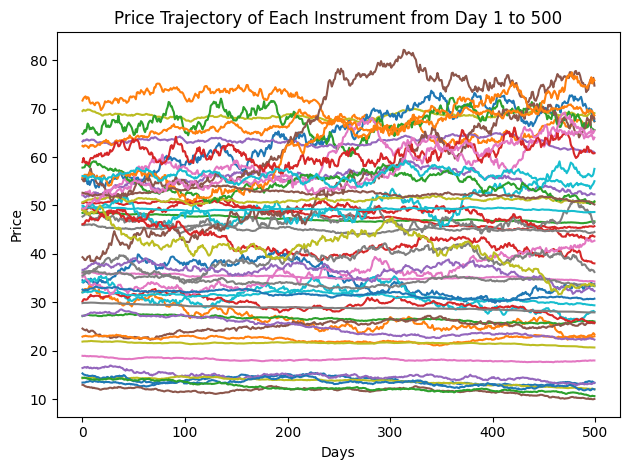

In [10]:
instruments_to_plot = range(50)

for i in instruments_to_plot:
    plt.plot(prcAll[i, :], label=f'Instrument {i}')

plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Price Trajectory of Each Instrument from Day 1 to 500')
plt.tight_layout()
plt.show()

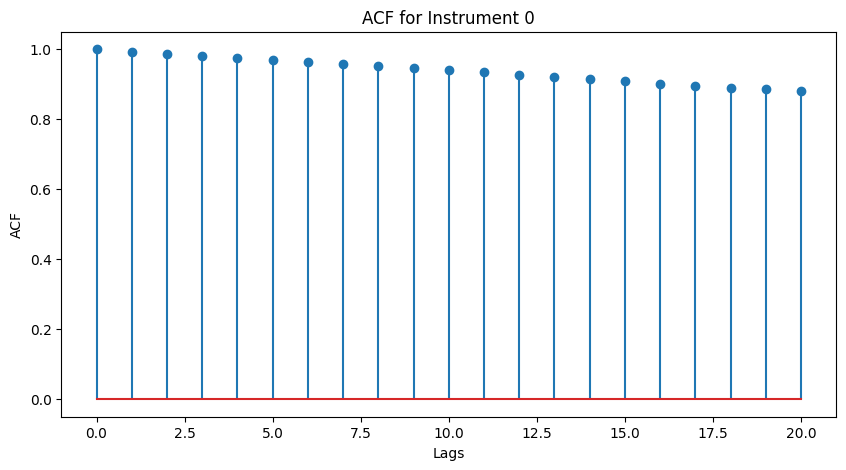

In [5]:
from statsmodels.tsa.stattools import acf

# Calculate ACF for each instrument
acf_values = []
for i in range(prcAll.shape[0]):
    acf_values.append(acf(prcAll[i, :], nlags=20))

# Plot ACF for the first instrument as an example
plt.figure(figsize=(10, 5))
plt.stem(acf_values[0])
plt.title('ACF for Instrument 0')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()